In [ ]:
"""
Summary:
This notebook combines the analysis and comparison of various active learning strategies 
on the classification problem of power grid security (secure / insecure).  

It includes testing of strategies (uncertainty, random, margin, entropy) under two validation scenarios:

1) random splitting of data (train_test_split)
2) sequential splitting (preserving temporal order of samples)

It saves plots with timestamps and records final results in a CSV summary table.
"""

'\nSummary:\nThis notebook combines the analysis and comparison of various active learning strategies \non the classification problem of power grid security (secure / insecure).  \nIt includes testing of strategies (uncertainty, random, margin, entropy, \nexpected error reduction, and density-weighted sampling) under two validation scenarios:\n\n1) random splitting of data (train_test_split)\n2) sequential splitting (preserving temporal order of samples)\n\nIt saves plots with timestamps and records final results in a CSV summary table.\n'

In [26]:
# ==============================================
# Imports & Data Loading
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import csv
import os
from time import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

from skactiveml.classifier import SklearnClassifier
from skactiveml.utils import MISSING_LABEL
from skactiveml.pool import (
    UncertaintySampling,
    RandomSampling,
    # DensityWeightedSampling,
    # ExpectedErrorReduction
)

In [27]:
# ==============================================
# Load dataset
# ==============================================

data = pd.read_csv("../data/simulation_security_labels_n-1.csv")
data["status_binary"] = data["status"].map({"secure": 1, "insecure": 0})

# Drop unused columns
columns_to_drop = [
    "timestamp", "status", "status_binary",
    "max_line_loading_percent_basecase",
    "min_bus_voltage_pu_basecase",
    "max_bus_voltage_pu_basecase",
    "max_line_loading_percent_contingency",
    "min_bus_voltage_pu_contingency",
    "max_bus_voltage_pu_contingency"
]
X = data.drop(columns=columns_to_drop, errors="ignore")
y = data["status_binary"]

In [28]:
X

,load_0_p_mw,load_1_p_mw,load_2_p_mw,load_3_p_mw,load_4_p_mw,load_5_p_mw,load_6_p_mw,load_7_p_mw,load_8_p_mw,load_9_p_mw,...,sgen_100_p_mw,sgen_101_p_mw,sgen_102_p_mw,sgen_103_p_mw,sgen_104_p_mw,sgen_105_p_mw,sgen_106_p_mw,sgen_107_p_mw,sgen_108_p_mw,sgen_109_p_mw
0,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00,...,9.272727,9.272727,9.272727,9.272727,14.833333,14.833333,14.833333,14.833333,14.833333,14.833333
1,207.80,207.80,207.80,207.80,207.80,207.80,207.80,207.80,207.80,207.80,...,10.227273,10.227273,10.227273,10.227273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,199.35,199.35,199.35,199.35,199.35,199.35,199.35,199.35,199.35,199.35,...,11.295455,11.295455,11.295455,11.295455,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667
3,188.80,188.80,188.80,188.80,188.80,188.80,188.80,188.80,188.80,188.80,...,13.022727,13.022727,13.022727,13.022727,4.833333,4.833333,4.833333,4.833333,4.833333,4.833333
4,181.60,181.60,181.60,181.60,181.60,181.60,181.60,181.60,181.60,181.60,...,14.431818,14.431818,14.431818,14.431818,4.833333,4.833333,4.833333,4.833333,4.833333,4.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8764,345.85,345.85,345.85,345.85,345.85,345.85,345.85,345.85,345.85,345.85,...,7.000000,7.000000,7.000000,7.000000,214.166667,214.166667,214.166667,214.166667,214.166667,214.166667
8765,329.75,329.75,329.75,329.75,329.75,329.75,329.75,329.75,329.75,329.75,...,8.045455,8.045455,8.045455,8.045455,194.333333,194.333333,194.333333,194.333333,194.333333,194.333333
8766,298.20,298.20,298.20,298.20,298.20,298.20,298.20,298.20,298.20,298.20,...,9.431818,9.431818,9.431818,9.431818,144.333333,144.333333,144.333333,144.333333,144.333333,144.333333
8767,263.05,263.05,263.05,263.05,263.05,263.05,263.05,263.05,263.05,263.05,...,11.568182,11.568182,11.568182,11.568182,96.166667,96.166667,96.166667,96.166667,96.166667,96.166667


In [29]:
y

0       1
1       1
2       0
3       0
4       1
       ..
8764    0
8765    0
8766    0
8767    0
8768    1
Name: status_binary, Length: 8769, dtype: int64

In [30]:
# ==============================================
# 3) Define Splits
# ==============================================

test_size = 0.1

# Random split
X_pool_random, X_val_random, y_pool_random, y_val_random = train_test_split(
    X, y, test_size=test_size, random_state=42
)

# Sequential split (preserving time)
split_index = int((1 - test_size) * len(X))
X_pool_time = X.iloc[:split_index]
y_pool_time = y.iloc[:split_index]
X_val_time = X.iloc[split_index:]
y_val_time = y.iloc[split_index:]

In [31]:
# ==============================================
# 4) Active Learning Loop
# ==============================================

def run_active_learning(
    X_pool, y_pool, X_val, y_val,
    strategy_type="uncertainty",
    initial_size=100, batch_size=50, iterations=40
):
    
    print("All class labels:", np.unique(y_pool))

    base_model = RandomForestClassifier(n_estimators=100, random_state=42)
    model = SklearnClassifier(estimator=base_model)

    # choose sampling strategy
    if strategy_type == "uncertainty":
        strategy = UncertaintySampling()
    elif strategy_type == "random":
        strategy = RandomSampling()
    elif strategy_type == "entropy":
        strategy = UncertaintySampling(method="entropy")
    elif strategy_type == "margin":
        strategy = UncertaintySampling(method="margin_sampling")
    # elif strategy_type == "density":
    #     strategy = DensityWeightedSampling()
    # elif strategy_type == "expected_error":
    #     strategy = ExpectedErrorReduction()
    else:
        raise ValueError("Invalid strategy_type")

    # initialize labeled pool
    y_train = np.full(len(X_pool), MISSING_LABEL)
    initial_idx = np.random.choice(range(len(X_pool)), size=initial_size, replace=False)


    # from sklearn.model_selection import StratifiedShuffleSplit
    # sss = StratifiedShuffleSplit(n_splits=1, train_size=initial_size, random_state=42)
    # initial_idx, _ = next(sss.split(X_pool, y_pool))

    from collections import Counter
    print("Initial class distribution:", Counter(y_pool.iloc[initial_idx]))

    y_train[initial_idx] = y_pool.iloc[initial_idx]

    metrics_per_iteration = []

    for i in range(iterations):
        
        model.fit(X_pool, y_train)

        # labeled_y = y_train[y_train != -1]
        labeled_y = y_train[~pd.isna(y_train)]
        print(f"[{strategy_type.upper()}] Iter {i+1} - Classes in current training:", np.unique(labeled_y))

        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:,1]

        # acc = accuracy_score(y_val, y_pred)
        # prec = precision_score(y_val, y_pred, zero_division=0)
        # rec = recall_score(y_val, y_pred, zero_division=0)
        # f1 = f1_score(y_val, y_pred, zero_division=0)
        # auc = roc_auc_score(y_val, y_prob)
        # cm = confusion_matrix(y_val, y_pred)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, zero_division=0, average="macro", pos_label=1)
        rec = recall_score(y_val, y_pred, zero_division=0, average="macro", pos_label=1)
        f1 = f1_score(y_val, y_pred, zero_division=0, average="macro", pos_label=1)
        auc = roc_auc_score(y_val, y_prob)
        cm = confusion_matrix(y_val, y_pred)

        metrics_per_iteration.append({
            "iteration": i+1,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": auc,
            "confusion_matrix": cm.tolist()
        })

        print(f"Iter {i+1} [{strategy_type}] - acc:{acc:.4f}, f1:{f1:.4f}, auc:{auc:.4f}")

        if len(X_pool) < batch_size:
            print("No more samples to query, stopping early.")
            break

        if strategy_type in ["uncertainty", "entropy", "margin"]: # "density", "expected_error"]
            print(f"X_pool shape: {X_pool.shape}, y_train unlabeled: {np.sum(pd.isna(y_train))}")

            print(f"Batch size: {batch_size}, X_pool shape: {X_pool.shape}")
            print(f"Unlabeled in y_train: {np.sum(pd.isna(y_train))}")
            print(f"Labeled: {np.sum(~pd.isna(y_train))}")
            print(f"Candidate indices: {len(np.arange(len(X_pool)))}")


            # Reset indices to avoid index mismatch issues
            X_pool = X_pool.reset_index(drop=True)
            y_pool = y_pool.reset_index(drop=True)
            y_train = pd.Series(y_train).reset_index(drop=True).to_numpy()

            # Filter candidates (only unlabeled ones)
            candidates = np.where(pd.isna(y_train))[0]

            # Call strategy
            query_idx, scores = strategy.query(X_pool, y=y_train, clf=model, candidates=candidates, batch_size=batch_size, return_utilities=True)

            print("Top 5 selected samples and their scores:")
            for idx, score in zip(query_idx[:5], scores[:5]):
                print(f"  idx={idx}, type={type(score)}, value={score}")
        else:
            candidates = np.where(pd.isna(y_train))[0]
            query_idx, scores = strategy.query(X_pool, y=y_train, candidates=candidates, batch_size=batch_size, return_utilities=True)

            print("Top 5 randomly selected samples and their scores:")
            
            for idx, score in zip(query_idx[:5], scores[:5]):
                print(f"  idx={idx}, type={type(score)}, value={score}")

        y_train[query_idx] = y_pool.iloc[query_idx]

    return metrics_per_iteration

In [32]:
# ==============================================
# 5) Run Experiments
# ==============================================

initial_size = 100
batch_size = 50
iterations = 40 #40

strategies_list = [
    "uncertainty", 
    "random", 
    "entropy", 
    "margin", 
    # "density", 
    # "expected_error"
]

results_random = {}
results_time = {}

start_time = time()

for strat in strategies_list:
    results_random[strat] = run_active_learning(
        X_pool_random.copy(), y_pool_random.copy(), X_val_random, y_val_random,
        strategy_type=strat,
        initial_size=initial_size,
        batch_size=batch_size,
        iterations=iterations
    )
    results_time[strat] = run_active_learning(
        X_pool_time.copy(), y_pool_time.copy(), X_val_time, y_val_time,
        strategy_type=strat,
        initial_size=initial_size,
        batch_size=batch_size,
        iterations=iterations
    )

end_time = time()
duration = round(end_time - start_time, 2)

All class labels: [0 1]
Initial class distribution: Counter({1: 55, 0: 45})
[UNCERTAINTY] Iter 1 - Classes in current training: [0. 1.]
Iter 1 [uncertainty] - acc:0.8495, f1:0.8494, auc:0.9216
X_pool shape: (7892, 265), y_train unlabeled: 7792
Batch size: 50, X_pool shape: (7892, 265)
Unlabeled in y_train: 7792
Labeled: 100
Candidate indices: 7892
Top 5 selected samples and their scores:
  idx=7632, type=<class 'numpy.ndarray'>, value=[0.   0.45 0.21 ... 0.18 0.31 0.46]
  idx=1691, type=<class 'numpy.ndarray'>, value=[0.   0.45 0.21 ... 0.18 0.31 0.46]
  idx=6439, type=<class 'numpy.ndarray'>, value=[0.   0.45 0.21 ... 0.18 0.31 0.46]
  idx=2254, type=<class 'numpy.ndarray'>, value=[0.   0.45 0.21 ... 0.18 0.31 0.46]
  idx=4265, type=<class 'numpy.ndarray'>, value=[0.   0.45 0.21 ... 0.18 0.31 0.46]
[UNCERTAINTY] Iter 2 - Classes in current training: [0. 1.]
Iter 2 [uncertainty] - acc:0.8689, f1:0.8689, auc:0.9292
X_pool shape: (7892, 265), y_train unlabeled: 7742
Batch size: 50, X_poo

Plot saved as: ../figures/al_strategy_comparison_random_20250715_115744.png


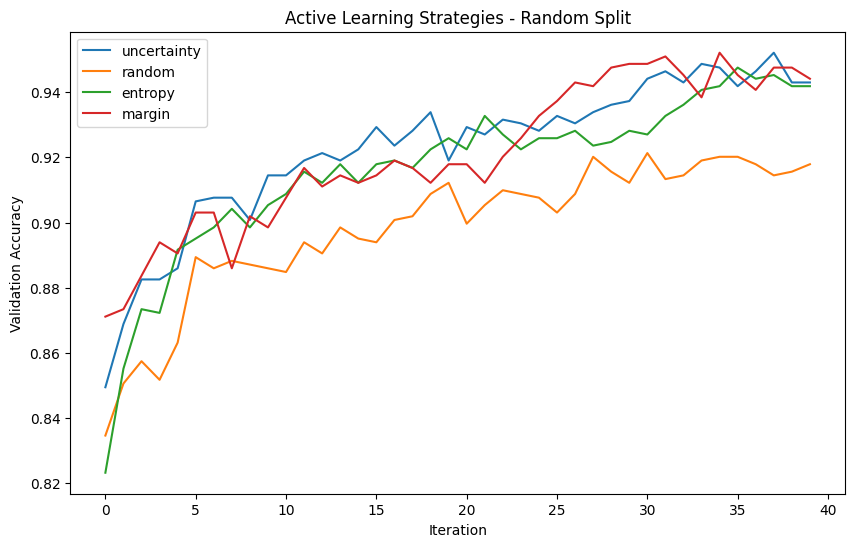

Plot saved as: ../figures/al_strategy_comparison_time_20250715_115744.png


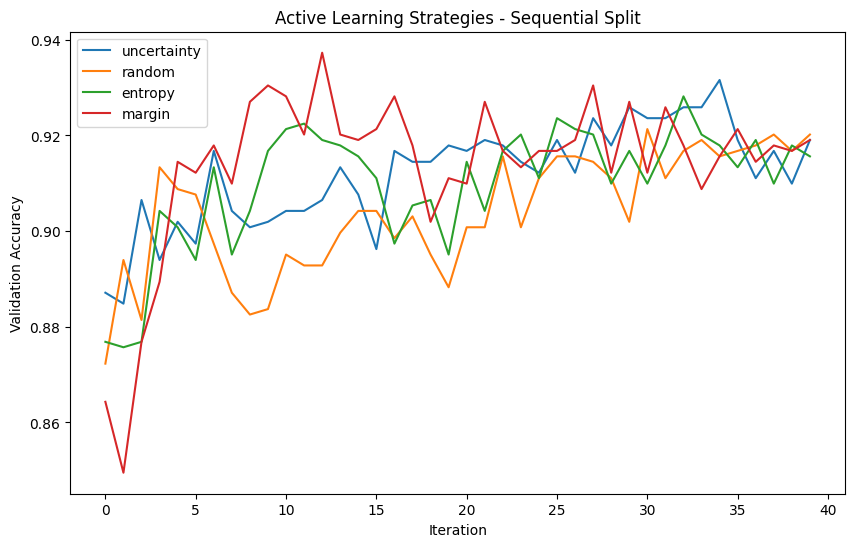

In [33]:
# ==============================================
# 6) Plot and Save Figures
# ==============================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# random split plot
plt.figure(figsize=(10,6))
for strat in strategies_list:
    accs = [m["accuracy"] for m in results_random[strat]]
    plt.plot(accs, label=strat)
plt.title("Active Learning Strategies - Random Split")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.legend()
fig = plt.gcf()
plot_filename = f"../figures/al_strategy_comparison_random_{timestamp}.png"
fig.savefig(plot_filename)
print(f"Plot saved as: {plot_filename}")
plt.show()

# sequential split plot
plt.figure(figsize=(10,6))
for strat in strategies_list:
    accs = [m["accuracy"] for m in results_time[strat]]
    plt.plot(accs, label=strat)
plt.title("Active Learning Strategies - Sequential Split")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.legend()
fig = plt.gcf()
plot_filename = f"../figures/al_strategy_comparison_time_{timestamp}.png"
fig.savefig(plot_filename)
print(f"Plot saved as: {plot_filename}")
plt.show()

In [34]:
# ==============================================
# 7) Save Results to CSV
# ==============================================

total_labeled = initial_size + iterations * batch_size
duration_sec = duration

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
csv_path = f"../tables/active_learning_runs_{timestamp}.csv"

fieldnames = [
    "timestamp", "strategy_type", "split_type", "iterations", "test_size",
    "initial_size", "batch_size", "total_labeled_samples", 
    "accuracy_final", "accuracy_mean", "accuracy_std", 
    "precision_mean", "recall_mean", "f1_mean", "roc_auc_mean", 
    "duration_sec"
]

with open(csv_path, mode="w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    # random split
    for strat, metrics in results_random.items():
        accuracy_vals = [m["accuracy"] for m in metrics]
        precision_vals = [m["precision"] for m in metrics]
        recall_vals = [m["recall"] for m in metrics]
        f1_vals = [m["f1"] for m in metrics]
        roc_auc_vals = [m["roc_auc"] for m in metrics]
        
        writer.writerow({
            "timestamp": timestamp,
            "strategy_type": strat,
            "split_type": "random",
            "iterations": iterations,
            "test_size": test_size,
            "initial_size": initial_size,
            "batch_size": batch_size,
            "total_labeled_samples": total_labeled,
            "accuracy_final": accuracy_vals[-1],
            "accuracy_mean": np.mean(accuracy_vals),
            "accuracy_std": np.std(accuracy_vals),
            "precision_mean": np.mean(precision_vals),
            "recall_mean": np.mean(recall_vals),
            "f1_mean": np.mean(f1_vals),
            "roc_auc_mean": np.mean(roc_auc_vals),
            "duration_sec": duration_sec
        })

    # time-based split
    for strat, metrics in results_time.items():
        accuracy_vals = [m["accuracy"] for m in metrics]
        precision_vals = [m["precision"] for m in metrics]
        recall_vals = [m["recall"] for m in metrics]
        f1_vals = [m["f1"] for m in metrics]
        roc_auc_vals = [m["roc_auc"] for m in metrics]
        
        writer.writerow({
            "timestamp": timestamp,
            "strategy_type": strat,
            "split_type": "sequential",
            "iterations": iterations,
            "test_size": test_size,
            "initial_size": initial_size,
            "batch_size": batch_size,
            "total_labeled_samples": total_labeled,
            "accuracy_final": accuracy_vals[-1],
            "accuracy_mean": np.mean(accuracy_vals),
            "accuracy_std": np.std(accuracy_vals),
            "precision_mean": np.mean(precision_vals),
            "recall_mean": np.mean(recall_vals),
            "f1_mean": np.mean(f1_vals),
            "roc_auc_mean": np.mean(roc_auc_vals),
            "duration_sec": duration_sec
        })

print(f"Summary table saved to: {csv_path}")


# save also to .xlsx
df = pd.read_csv(csv_path)
xlsx_path = csv_path.replace(".csv", ".xlsx")
df.to_excel(xlsx_path, index=False)

print(f"Excel file also saved to: {xlsx_path}")

Summary table saved to: ../tables/active_learning_runs_2025-07-15_11-57-45.csv
Excel file also saved to: ../tables/active_learning_runs_2025-07-15_11-57-45.xlsx
